# Dec 6-10, 2023: simulated time series data for network inference

In [1]:
import numpy as np

import matplotlib.pyplot as plt

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

---

In [2]:
def rate_kuramoto(theta,w,K):    
    '''
    input:
    theta is a 1d array encoding the current state of the nodes.
    w is the natural frequency.
    K is a matrix encoding the strengths of connections.
    
    output:
    dtheta (d theta / dt) is the rate of theta.
    '''
    N = len(w)
    delta = np.array([list(theta)]*N) # pairwise phase difference
    delta -= delta.T # pairwise phase difference
    delta = np.sin(delta) # sine of the pairwise phase difference
    
    dtheta =  w + np.sum(K*delta,axis=1)/N 
    
    return dtheta

In [3]:
def likelihood_model(theta, params):
    '''
    input:
    theta is a NxT array encoding the current state of the nodes (1 to N) at different times (0 to T).
    params is a dict containing all model parameters including w_M (natural frequency), K_m (connection strength matrix)
    and dt (the infinitesimal time step size)
    
    output:
    likelihood
    '''
    delta_theta =  theta[1:-1] - theta[0:-2] # the empirical rate
    delta_theta_M = np.array([ rate_kuramoto(i,params['w_M'],params['K_M']) for i in theta[0:-2] ])*params['dt'] # model rate
    delta = np.array([ np.linalg.norm(delta_theta_M[i]-delta_theta[i]) for i in range(len(delta_theta))  ]) # their difference
    beta = .001 # can be a parameter, but let's fix it later
    return np.prod(np.exp(-beta*delta))

---

## nonlinear 1D sigmoid model

In [4]:
def dx(t, x, P, I):
    '''
    t: () index of time
    x: (N,) vector of state of the system
    P: dictionary of parameters
    I: (T,) vector of external input
    '''
    N = len(x)
    
    # deterministic part
    sigmoid = lambda x: 1 / (1 + np.exp(-x)) - 0.5 # center sigmoid to 0
    F = -P['A']*x + P['B'] + P['K']@x + P['s']*I[t]
    F = sigmoid(F)
    
    # stochastic part
    G = P['sigma']*np.eye(N)
    
    # model
    dx = F * P['dt'] + G @ P['dN'][t]
    return dx 
    
    
def likelihood(t, xs, P, I):
    '''
    t: (T,) vector of time points
    xs: (T, N) array of state of the system, x[idx_t, :] at time index idx_t
    P: dictionary of parameters
    I: (T,) vector of external input
    '''
    # empirical rate
    delta_x_emp = xs[1:, :] - xs[:-1, :]
    
    # model rate
    delta_x_model = np.stack([dx(t=idx_t, x=xs[idx_t, :], P=P, I=I) for idx_t in range(len(t)-1)], axis=0)
    
    # likelihood
    delta = np.stack([np.linalg.norm(delta_x_model[i] - delta_x_emp[i]) for i in range(len(delta_x_emp))], axis=0)
    beta = 0.001 
    return np.prod(np.exp(-beta*delta))

In [5]:
N = 5 # num nodes
T_span = 100 # seconds

# basic params
P = {
    'dt': 0.1, # seconds
    'A': 15*np.ones((N)), 
    'B': 0.0,
    'sigma': 0.01,
}

# network, K
K = 10*np.eye(N)
K = np.roll(K, shift=1, axis=-1)
P['K'] = K

# time points
t = np.arange(start=0.0, stop=T_span, step=P['dt']) # time
T = len(t) # num time points

# external input, I(t): stimulus
P['s'] = np.array([1.0] + [0.0]*(N-1))
P['T_s'] = 25.0 # seconds
P['tau'] = 10.0 # seconds
I = (np.mod(t, P['T_s']) < P['tau']).astype(np.float32)

# stochastic noise, dN(t): Weiner process
P['dN'] = np.random.normal(loc=0.0, scale=np.sqrt(P['dt']), size=(T, N))

In [6]:
xs = []
x = np.zeros((N))
for idx_t in range(len(t)):
    xs.append(x.copy())
    x += dx(t=idx_t, x=x, P=P, I=I)
xs = np.stack(xs, axis=0)

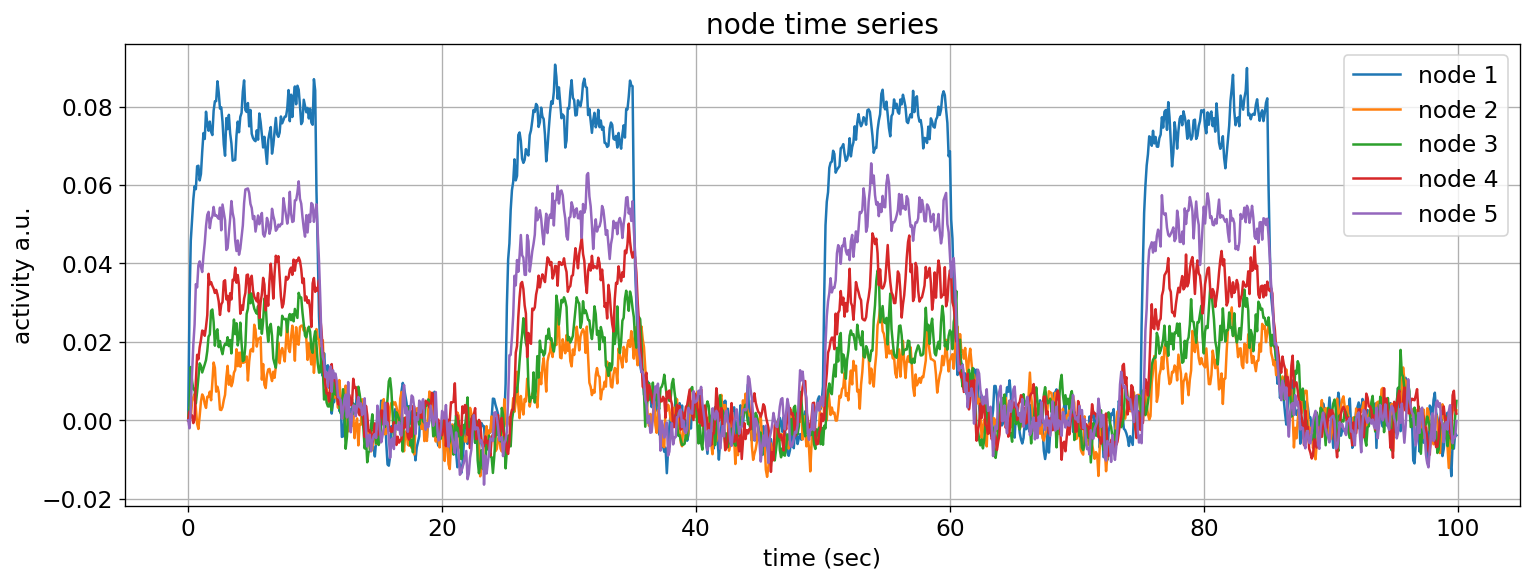

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5), dpi=120)
ax = axs
for idx_node in range(N):
    ax.plot(t, xs[:, idx_node], label=f'node {idx_node+1}')
ax.set(title='node time series', xlabel='time (sec)', ylabel='activity a.u.')
ax.legend()
ax.grid(True)

In [8]:
P['sigma'] = 0.0 # ignore stochastic part of the dyn. sys.
likelihood(t, xs, P, I)

0.993243631926936

---

## reduced Wong-Wang model

In [9]:
def dx(t, x, P, I):
    '''
    t: () index of time
    x: (N,) vector of state of the system
    P: dictionary of parameters
    I: (T,) vector of external input
    '''
    N = len(x)
    
    # deterministic part
    H = lambda x: (P['a']*x - P['b']) / (1 - np.exp(-P['d']*(P['a']*x - P['b'])))
    s = P['w']*P['J_N']*x + P['J_N']*P['K']@x + P['s']*I[t]
    F = -x/P['tau'] + P['gamma']*(1-x)*H(s)
    
    # stochastic part
    G = P['sigma']*np.eye(N)
    
    # model
    dx = F * P['dt'] + G @ P['dN'][t]
    return dx 
    
    
def likelihood(t, xs, P, I):
    '''
    t: (T,) vector of time points
    xs: (T, N) array of state of the system, x[idx_t, :] at time index idx_t
    P: dictionary of parameters
    I: (T,) vector of external input
    '''
    # empirical rate
    delta_x_emp = xs[1:, :] - xs[:-1, :]
    
    # model rate
    delta_x_model = np.stack([dx(t=idx_t, x=xs[idx_t, :], P=P, I=I) for idx_t in range(len(t)-1)], axis=0)
    
    # likelihood
    delta = np.stack([np.linalg.norm(delta_x_model[i] - delta_x_emp[i]) for i in range(len(delta_x_emp))], axis=0)
    beta = 0.001 
    return np.prod(np.exp(-beta*delta))

In [10]:
N = 5 # num nodes
T_span = 100 # seconds

# basic params
P = {
    'dt': 0.1, # seconds
    'a': 0.270, 
    'b': 0.100,
    'd': 154.0,
    'gamma': 0.641,
    'tau':100.0,
    'w': 0.6,
    'J_N': 0.2609,
    'sigma': 0.01,
}

# network, K
K = 1*np.eye(N)
K = np.roll(K, shift=1, axis=-1)
P['K'] = K

# time points
t = np.arange(start=0.0, stop=T_span, step=P['dt']) # time
T = len(t) # num time points

# external input, I(t): stimulus
P['s'] = np.array([0.0] + [0.0]*(N-1))
P['T_s'] = 25.0 # seconds
P['tau_s'] = 10.0 # seconds
I = (np.mod(t, P['T_s']) < P['tau_s']).astype(np.float32)

# stochastic noise, dN(t): Weiner process
P['dN'] = np.random.normal(loc=0.0, scale=np.sqrt(P['dt']), size=(T, N))

In [11]:
xs = []
x = np.zeros((N))
for idx_t in range(len(t)):
    xs.append(x.copy())
    x += dx(t=idx_t, x=x, P=P, I=I)
xs = np.stack(xs, axis=0)

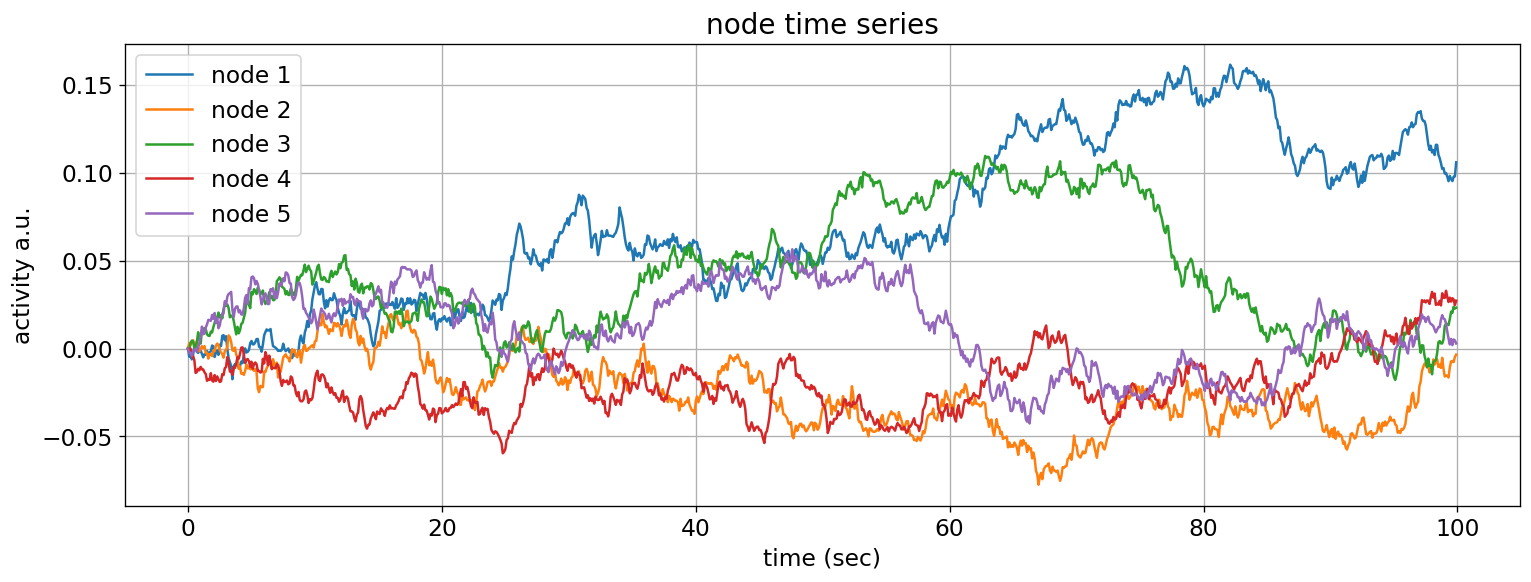

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5), dpi=120)
ax = axs
for idx_node in range(N):
    ax.plot(t, xs[:, idx_node], label=f'node {idx_node+1}')
ax.set(title='node time series', xlabel='time (sec)', ylabel='activity a.u.')
ax.legend()
ax.grid(True)

In [13]:
P['sigma'] = 0.0 # ignore stochastic part of the dyn. sys.
likelihood(t, xs, P, I)

0.9933374754845237